# InceptionResNetV2

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## Step1: Load the Traning Data

In [5]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.2960.jpg,0
1,dog.11107.jpg,1
2,cat.3056.jpg,0
3,cat.12279.jpg,0
4,dog.7786.jpg,1


## Step2: Build Model

In [6]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import InceptionResNetV2
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = InceptionResNetV2(input_shape=input_shape, include_top=False, weights="imagenet")

# Add Layers
x = pre_trained_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()









219062272/219055592 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
______________________

block17_2_ac (Activation)       (None, 12, 12, 1088) 0           block17_2[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 12, 12, 128)  139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 12, 12, 128)  384         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_86 (Activation)      (None, 12, 12, 128)  0           batch_normalization_86[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 12, 12, 160)  143360      activation_86[0][0]              
__________________________________________________________________________________________________
batch_norm

## Step3: Prepare Test and Train Data

In [7]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
train_df["category"] = train_df["category"].astype(str)
validate_df["category"] = validate_df["category"].astype(str)

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [9]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


## Step4: Fit Model

In [10]:
# Fit the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/5
1406/1406 [==============================] - 1341s 954ms/step - loss: 0.1974 - acc: 0.9183 - val_loss: 0.2566 - val_acc: 0.9655
Epoch 2/5
1406/1406 [==============================] - 1303s 927ms/step - loss: 0.0979 - acc: 0.9615 - val_loss: 0.1680 - val_acc: 0.9750
Epoch 3/5
1406/1406 [==============================] - 1300s 925ms/step - loss: 0.0808 - acc: 0.9679 - val_loss: 0.2550 - val_acc: 0.9702
Epoch 4/5
1406/1406 [==============================] - 1301s 925ms/step - loss: 0.0678 - acc: 0.9748 - val_loss: 0.2469 - val_acc: 0.9730
Epoch 5/5
1406/1406 [==============================] - 1301s 925ms/step - loss: 0.0567 - acc: 0.9780 - val_loss: 0.2197 - val_acc: 0.9726


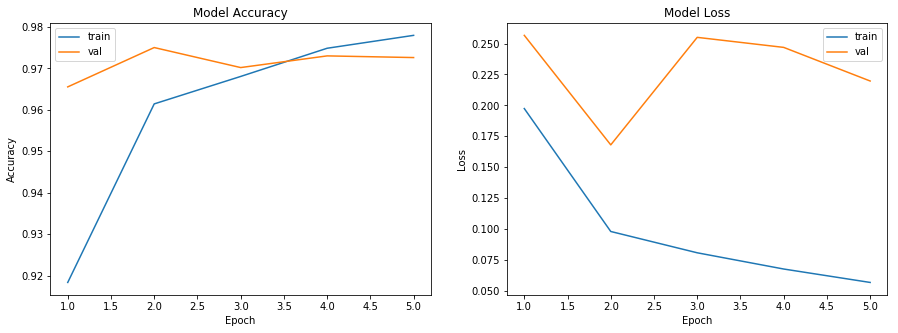

In [11]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

## Step5: Testing Data

In [12]:
test_filenames = os.listdir("./test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [13]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


In [14]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

## Step6: Result

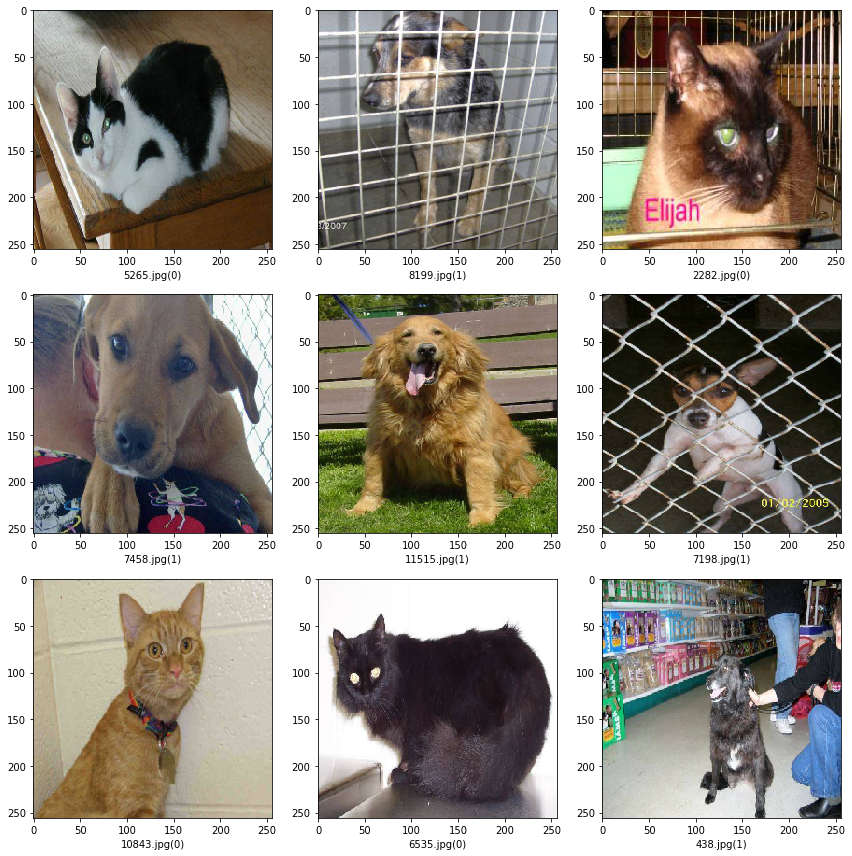

In [15]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

## Step7: Create Submission

In [16]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_InceptionResNetV2.csv', index=False)